https://keras.io/examples/keras_recipes/bayesian_neural_networks/

https://keras.io/examples/generative/vae/

References:

1. Generative Deep Learning - David Foster
2. Variational Autoencoder: Intuition and Implementation - Agustinus Kristiadi
3. Deep Learning with Python - Francois Chollet

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import datasets

In [6]:
from model import ScNN

# Generating Dataset

System: In 2D space, a free particle (A) and a particle (B) constrained to move on a circle.

The particle A is moving with initial velocity $u$ and the angular velocity of B is $\omega$. Their masses are $m_1\;\&\;m_2$ respectively.

Let the particle A collides with particle B at $(0, r).$ The final velocity of A is $v$ and final angular velocity of B is $\omega'$.

In [8]:
def generateData(p1inx_min=-10, p1inx_max=-5, v1inx_min=0.1, v1inx_max=1, v1iny_min=-0.5, v1iny_max=0.5, omega_min=-1, omega_max=1, r=1, m1=1, m2=1, units=5, samples=1000):
  p1inx = np.random.uniform(low=p1inx_min, high=p1inx_max, size=(samples,1))
  v1inx = np.random.uniform(low=v1inx_min, high=v1inx_max, size=(samples,1))
  v1iny = np.random.uniform(low=v1iny_min, high=v1iny_max, size=(samples,1))
  #v1finx = np.random.uniform(low=v1inx_min/2, high=v1iny_max/2, size=(samples,1))
  #v1finy = np.random.uniform(low=v1iny_min/2, high=v1iny_max/2, size=(samples,1))
  omega = np.random.uniform(low=omega_min, high=omega_max, size=(samples,1))

  v1finx_threshold = np.sqrt(v1inx**2 + m2*r**2*omega**2/m1)
  v1finx = np.random.uniform(low=-v1finx_threshold/1.1, high=v1finx_threshold/1.1, size=(samples, 1))
  v1finy = v1inx

  t_collision = -p1inx/v1inx

  p1iny = r - v1iny*t_collision
  #p2inx = -r*np.cos(omega*t_collision)
  #p2iny = -r*np.sin(omega*t_collision)

  l2in = m2*omega*r**2
  l1in = m1*(p1inx*v1iny - p1iny*v1inx)
  lin = l1in + l2in

  t_pre_collision = np.linspace(start=t_collision-5, stop=t_collision, num=units, axis=1)[:,:,0]
  t_post_collision = np.linspace(start=t_collision, stop=t_collision+5, num=units, axis=1)[:,:,0]
  #step = 10/units
  #diff = np.random.uniform(low=-step/units, high=step/units, size=(samples, units))
  #t_pre_collision = t_pre_collision + diff
  #diff = np.random.uniform(low=-step/units, high=step/units, size=(samples, units))
  #t_post_collision = t_post_collision + diff
  #t_pre_collision = np.random.uniform(low=t_collision-10, high=t_collision-1, size=(samples, units))
  #t_post_collision = np.random.uniform(low=t_collision+1, high=t_collision+10, size=(samples, units))

  p1x_pre = p1inx + v1inx*t_pre_collision
  p1y_pre = p1iny + v1iny*t_pre_collision
  p2x_pre = -r*np.sin(omega*(t_pre_collision-t_collision))
  p2y_pre = r*np.cos(omega*(t_pre_collision-t_collision))
  #p2x_pre = p2inx + r*np.cos(omega*t_pre_collision)
  #p2y_pre = p2iny + r*np.sin(omega*t_pre_collision)
  #p1x_post = p1inx + v1finx*t_post_collision
  #p1y_post = p1iny + v1finy*t_post_collision
  p1x_post = v1finx*(t_post_collision-t_collision)
  p1y_post = r + v1finy*(t_post_collision-t_collision)

  #l2fin = -m2*r*v1inx
  #l1fin = lin - l2fin
  #omega_fin = l2fin/(m2*r**2)
  omega_fin = omega + (v1finx - v1inx)*m1/(m2*r)

  p2x_post = -r*np.sin(omega_fin*(t_post_collision-t_collision))
  p2y_post = r*np.cos(omega_fin*(t_post_collision-t_collision))
  #p2x_post = r*np.cos(omega_fin*(t_post_collision-t_collision))
  #p2y_post = r*(1 + np.sin(omega_fin*(t_post_collision-t_collision)))

  t_prediction = t_collision + 5
  p2x_prediction = -r*np.sin(omega_fin*(t_prediction-t_collision))
  p2y_prediction = r*np.cos(omega_fin*(t_prediction-t_collision))

  return t_pre_collision, p1x_pre, p1y_pre, p2x_pre, p2y_pre, t_collision, t_post_collision, p1x_post, p1y_post, p2x_post, p2y_post, t_prediction, p2x_prediction, p2y_prediction, lin

In [44]:
samples = int(1e1)
units=50
t_pre_collision, p1x_pre, p1y_pre, p2x_pre, p2y_pre, t_collision, t_post_collision, p1x_post, p1y_post, p2x_post, p2y_post, t_prediction, p2x_prediction, p2y_prediction, lin = generateData(units=units, samples=samples)

[]

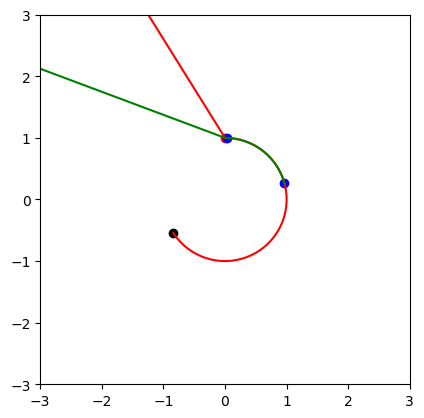

In [45]:
index1 = 9
plt.plot(p1x_pre[index1], p1y_pre[index1], c='red')
plt.plot(p1x_post[index1], p1y_post[index1], c='green')
plt.plot(p2x_pre[index1], p2y_pre[index1], c='red')
plt.plot(p2x_post[index1], p2y_post[index1], c='green')

plt.scatter(p2x_pre[index1,0], p2y_pre[index1,0], c='black')
plt.scatter(p2x_pre[index1,-1], p2y_pre[index1,-1], c='red')
plt.scatter(p2x_post[index1,[1,-1]], p2y_post[index1,[1,-1]], c='blue')
ax = plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')
plt.plot()

# Train Model

Each sample in the training consists of a time series of 50 positions of pendulum, the prediction time as a question and the corresponding answer to the question, which is the position o fthe pendulum.

A large sample is generated by varying the frequency and the damping parameter fo the pendulum. The parameters are randomly chosen in the specified range.

In [9]:
train_samples = int(5e5)
t_pre_collision_train, p1x_pre_train, p1y_pre_train, p2x_pre_train, p2y_pre_train, t_collision_train, t_post_collision_train, p1x_post_train, p1y_post_train, p2x_post_train, p2y_post_train, t_prediction_train, p2x_prediction_train, p2y_prediction_train, lin_train = generateData(omega_min=0.1, omega_max=1.5, samples=train_samples)
print(t_pre_collision_train.shape)
print(p1x_pre_train.shape)
print(p2x_pre_train.shape)

(500000, 5)
(500000, 5)
(500000, 5)


In [7]:
#input_size=50, encoder_layer=[70, 70], latent_size=3, question_size=1, decoder_layer=[70, 70], output_size=1, beta_rec=500., beta_kl=1., target_var=0.01
collision = ScNN(input_size=30, encoder_layer=[150, 100], latent_size=1, question_size=16, decoder_layer=[100, 100], output_size=2, beta_rec=1.0, beta_kl=0, activation='tanh')

In [10]:
learning_rate = 1e-3
batch_size=500
epochs=50

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
combined_input = np.concatenate((t_pre_collision_train, p1x_pre_train, p1y_pre_train, t_pre_collision_train, p2x_pre_train, p2y_pre_train), axis=1)
combined_question = np.concatenate((t_prediction_train, t_post_collision_train, p1x_post_train, p1y_post_train), axis=1)
combined_answer = np.column_stack((p2x_prediction_train, p2y_prediction_train))
collision.fit({'time_series': combined_input, 't_question': combined_question, 'answer': combined_answer}, batch_size=batch_size, epochs=epochs)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.6343 - total_loss: 0.6343
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0278 - total_loss: 0.0278
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0136 - total_loss: 0.0136
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0077 - total_loss: 0.0077
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0052 - total_loss: 0.0052
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0043 - total_loss: 0.0043
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0031 - total_loss: 0.0031
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0030 - tot

In [134]:
learning_rate = 5e-4
batch_size=500
epochs=100

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': [t_pre_collision_train, p1x_pre_train, p1y_pre_train, t_pre_collision_train, p2x_pre_train, p2y_pre_train], 't_question': [t_prediction_train, t_post_collision_train, p1x_post_train, p1y_post_train], 'answer': np.column_stack((p2x_prediction_train, p2y_prediction_train))}, batch_size=batch_size, epochs=epochs)

Epoch 1/100
1000/1000 [==============================] - 9s 7ms/step - reconstruction_loss: 3.5705e-04
Epoch 2/100
1000/1000 [==============================] - 8s 8ms/step - reconstruction_loss: 1.7497e-04
Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - reconstruction_loss: 2.0407e-04
Epoch 4/100
1000/1000 [==============================] - 8s 8ms/step - reconstruction_loss: 2.1984e-04
Epoch 5/100
1000/1000 [==============================] - 7s 7ms/step - reconstruction_loss: 2.0193e-04
Epoch 6/100
1000/1000 [==============================] - 10s 10ms/step - reconstruction_loss: 2.1666e-04
Epoch 7/100
1000/1000 [==============================] - 11s 11ms/step - reconstruction_loss: 1.6834e-04
Epoch 8/100
1000/1000 [==============================] - 7s 7ms/step - reconstruction_loss: 1.8654e-04
Epoch 9/100
1000/1000 [==============================] - 8s 8ms/step - reconstruction_loss: 2.0006e-04
Epoch 10/100
1000/1000 [==============================] - 7s 7ms/step

In [ ]:
learning_rate = 1e-4
batch_size=500
epochs=50

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': [t_pre_collision_train, p1x_pre_train, p1y_pre_train, t_pre_collision_train, p2x_pre_train, p2y_pre_train], 't_question': [t_prediction_train, t_post_collision_train, p1x_post_train, p1y_post_train], 'answer': np.column_stack((p2x_prediction_train, p2y_prediction_train))}, batch_size=batch_size, epochs=epochs)

Epoch 1/50
1000/1000 [==============================] - 9s 7ms/step - reconstruction_loss: 2.4620e-05
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - reconstruction_loss: 2.3037e-05
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - reconstruction_loss: 2.2620e-05
Epoch 4/50
1000/1000 [==============================] - 8s 8ms/step - reconstruction_loss: 2.2235e-05
Epoch 5/50
1000/1000 [==============================] - 8s 8ms/step - reconstruction_loss: 2.1912e-05
Epoch 6/50
1000/1000 [==============================] - 7s 7ms/step - reconstruction_loss: 2.2059e-05
Epoch 7/50
1000/1000 [==============================] - 8s 8ms/step - reconstruction_loss: 2.1707e-05
Epoch 8/50
1000/1000 [==============================] - 7s 7ms/step - reconstruction_loss: 2.1141e-05
Epoch 9/50
1000/1000 [==============================] - 9s 9ms/step - reconstruction_loss: 2.1172e-05
Epoch 10/50
1000/1000 [==============================] - 7s 7ms/step - reconstru

# Validating the model

The test sample is similarly generated. The answer to the question is predicted by the model for each sample.

In [11]:
test_samples = int(5e4)
t_test_pre_collision, p1x_test_pre, p1y_test_pre, p2x_test_pre, p2y_test_pre, t_test_collision, t_test_post_collision, p1x_test_post, p1y_test_post, p2x_test_post, p2y_test_post, t_test_prediction, p2x_test_prediction, p2y_test_prediction, lin_test = generateData(omega_min=0.1, omega_max=1.5, units=5, samples=test_samples)

[]

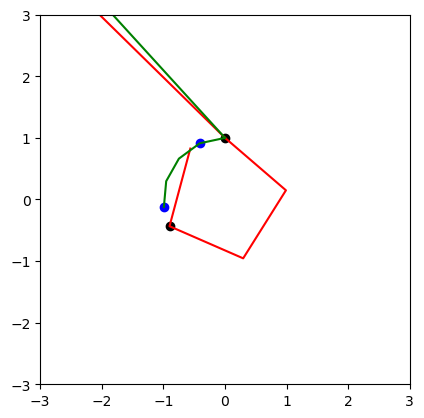

In [12]:
index1 = 2
plt.plot(p1x_test_pre[index1], p1y_test_pre[index1], c='red')
plt.plot(p1x_test_post[index1], p1y_test_post[index1], c='green')
plt.plot(p2x_test_pre[index1], p2y_test_pre[index1], c='red')
plt.plot(p2x_test_post[index1], p2y_test_post[index1], c='green')

plt.scatter(p2x_test_pre[index1,[1,-1]], p2y_test_pre[index1,[1,-1]], c='black')
plt.scatter(p2x_test_post[index1,[1,-1]], p2y_test_post[index1,[1,-1]], c='blue')
ax = plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')
plt.plot()

In [13]:
obs = np.concatenate((t_test_pre_collision, p1x_test_pre, p1y_test_pre, t_test_pre_collision, p2x_test_pre, p2y_test_pre), axis=1)
ques = np.concatenate((t_test_prediction, t_test_post_collision, p1x_test_post, p1y_test_post), axis=1)
#z_mu, z_logvar, z, x_test_prediction = collision.predict([obs, ques])
#z = encoder.predict(obs)
mean, log_var, z, x_test_prediction = collision.predict([obs, ques])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step


In [14]:
x_true = np.column_stack((p2x_test_prediction, p2y_test_prediction))
error_squared = (x_test_prediction - x_true)**2

In [15]:
mse = error_squared.sum(axis=1).mean()
mse

0.0017360064588564242

[]

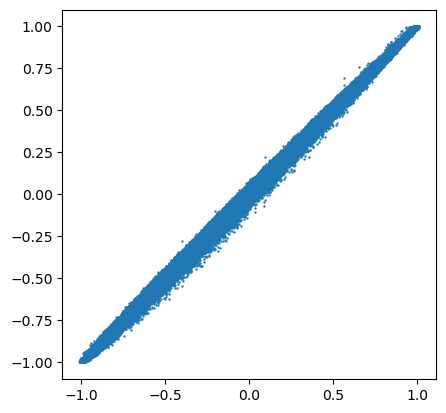

In [16]:
#plt.scatter(lin_test, z, s=0.5)
plt.scatter(x_test_prediction[:,0], x_true[:,0], s=0.5)
ax = plt.gca()
#ax.set_ylim(-2,2)
ax.set_aspect('equal')
plt.plot()

[]

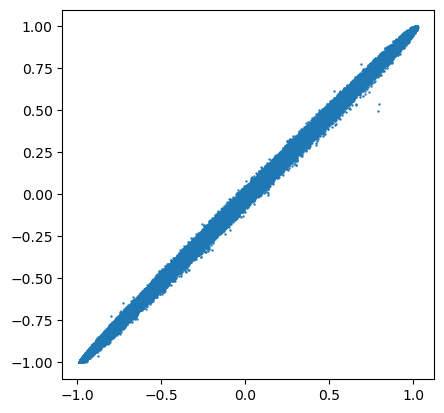

In [17]:
#plt.scatter(lin_test, z, s=0.5)
plt.scatter(x_test_prediction[:,1], x_true[:,1], s=0.5)
ax = plt.gca()
#ax.set_ylim(-2,2)
ax.set_aspect('equal')
plt.plot()

[]

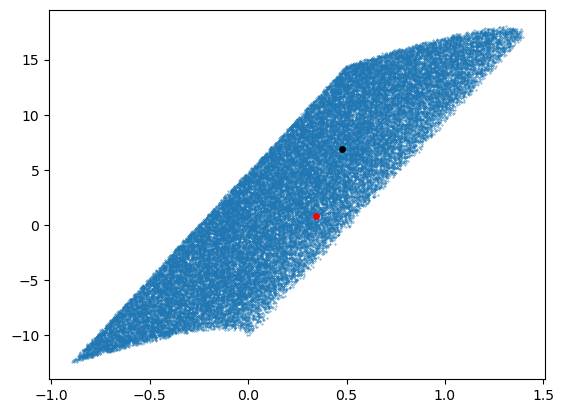

In [18]:
plt.scatter(lin_test, z, s=0.1)
plt.scatter(lin_test[15], z[15,0], s=15, c='black')
plt.scatter(lin_test[20], z[20,0], s=15, c='red')
#plt.scatter(x_test_prediction[:,0], x_true[:,0], s=0.5)
ax = plt.gca()
#ax.set_ylim(-2,2)
#ax.set_aspect('equal')
plt.plot()

# Denoising using Autoencoder

In [ ]:
variational_autoencoder = VAE(encoder, decoder, beta_rec=10., beta_kl=1)
variational_autoencoder.compile(optimizer='adam')
variational_autoencoder.fit(x_train_reshaped, x_train_reshaped, batch_size=128, epochs=10)

In [ ]:
latent_z_mu, latent_z_logvar, x_prediction_reshaped = variational_autoencoder.predict(x_test_reshaped)

Let us introduce some noise to the images and see how the autoencoder performs on the noised images.

In [ ]:
#create noises for the training and test datasets as random values
train_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_train_reshaped.shape[1]))
test_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_test_reshaped.shape[1]))

In [ ]:
#add the noise
x_train_noise = x_train_reshaped + train_noise
x_test_noise = x_test_reshaped + test_noise
#clip the noise in the range [0,1]
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

We see that the encoder is performing badly for the noised data. This is because the encoder is not trained to remove the noise. So, lets pass the encoder noised data and train it to produce denoised images.